# Bivariate choropleth

Main required libraries:
1. GeoPandas
2. Matplotlib

In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from adjustText import adjust_text
import contextily as ctx
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
import scienceplots
plt.style.use('science')

## Data loading and preprocessing

We have a simple data set with the following columns:
1. *PLN_AREA_N* - the name of planning areas in Singapore
2. *Name* - the ID of planning areas in Singapore
2. *rat_un_he* - the first variable of interest,
3. *lowinc_1k*/*lowinc_2k*/*lowinc_3k* - the second variable of interest,
4. *geometry* - district's geometry. The CRS of the geometry is EPSG:4326, but it can be any other. We're going to convert it to EPSG:3857 to use Contextily later on.

In [3]:
data = gpd.read_file('../../data/bivariables/data.shp')
boundary = gpd.read_file('../../data/bivariables/sg_boundary.shp')
data.head()

,PLN_AREA_N,rat_un_he,Name,lowinc_1k,lowinc_2k,lowinc_3k,geometry
0,ANG MO KIO,0.186899,kml_52,0.032053,0.118758,0.192010,"POLYGON ((30658.5 42047.527, 30679.195 42020.8..."
1,BEDOK,0.181129,kml_1,0.027287,0.092661,0.157627,"POLYGON ((38974.269 36138.243, 39371.471 35747..."
2,BISHAN,0.074724,kml_51,0.020294,0.059564,0.095917,"POLYGON ((29772.191 38311.805, 29784.826 38304..."
3,BOON LAY,0.000000,kml_2,0.000000,0.000000,0.000000,"POLYGON ((12861.383 32207.492, 12860.555 32208..."
4,BUKIT BATOK,0.287983,kml_3,0.017531,0.086412,0.149146,"POLYGON ((20294.455 39114.528, 20334.318 39054..."


### Exploratory data analysis

Key aspects to attend to:

1. **Data Quality**
- Ensure no missing or erroneous values in the variables
- Handle missing values appropriately

2. **Variables Selection**
- Variables should be continuous or ordinal which can be meaningfully combines

3. **Normalisation**
- Scaling the variables to a common range
- Transforming them to reduce skewness

       rat_un_he  lowinc_2k
count  55.000000  55.000000
mean    0.111281   0.044162
std     0.127505   0.049368
min     0.000000   0.000000
25%     0.000000   0.000000
50%     0.074724   0.031443
75%     0.201081   0.077160
max     0.425000   0.205837


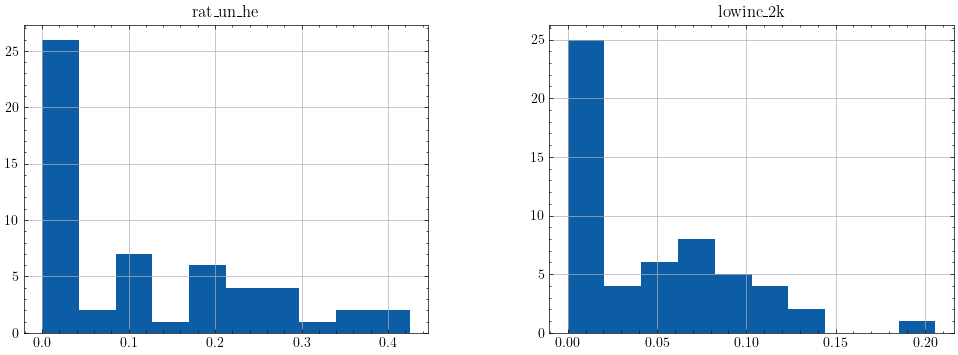

In [8]:
v1 = 'rat_un_he'
v2 = 'lowinc_2k'

print(data[[v1, v2]].describe())

data[[v1, v2]].hist(figsize=(12,4))
plt.show()

### Remove data points with missing values

       rat_un_he  lowinc_2k
count  28.000000  28.000000
mean    0.199245   0.084801
std     0.096843   0.036515
min     0.023635   0.031364
25%     0.121558   0.060061
50%     0.191744   0.077160
75%     0.267895   0.098780
max     0.414188   0.205837


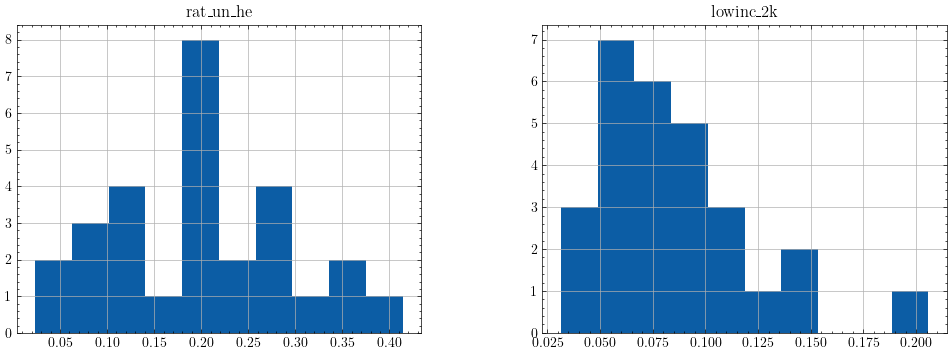

In [9]:
# remove the areas with no data
data = data[(data[v1] != 0) & (data[v2] != 0)]

       rat_un_he  lowinc_2k
count  28.000000  28.000000
mean    0.199245   0.084801
std     0.096843   0.036515
min     0.023635   0.031364
25%     0.121558   0.060061
50%     0.191744   0.077160
75%     0.267895   0.098780
max     0.414188   0.205837


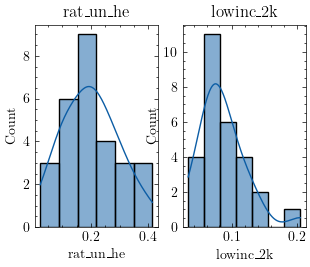

In [12]:
print(data[[v1, v2]].describe())

plt.subplot(1, 2, 1)
sns.histplot(data[v1], kde=True)
plt.title(v1)

plt.subplot(1, 2, 2)
sns.histplot(data[v2], kde=True)
plt.title(v2)

plt.show()

It is quite clear to see:
1. There have different ranges;

For variable 2 (income):
1. It might contains outliers;
2. The distribute is right-skewed. 

The strategy is to deal with individual variable first, then re-scale them to a common range.

Find if there are outliers through z-score:
1. Calculate the z-score of each value in the sample, relative to the sample mean and standard deviation.
2. Find the data points with z-score > 3 or < -3.

In [23]:
data[f'{v1}_z'] = stats.zscore(data[v1])
data[f'{v2}_z'] = stats.zscore(data[v2])

# Filter out the outliers
data = data[(np.abs(data[f'{v1}_z']) < 3) & (np.abs(data[f'{v2}_z']) < 3)]

       rat_un_he  lowinc_2k
count  27.000000  27.000000
mean    0.199948   0.080318
std     0.098615   0.028290
min     0.023635   0.031364
25%     0.118971   0.059896
50%     0.196589   0.077033
75%     0.271596   0.094070
max     0.414188   0.138329


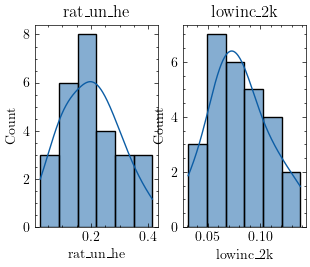

In [24]:
print(data[[v1, v2]].describe())

plt.subplot(1, 2, 1)
sns.histplot(data[v1], kde=True)
plt.title(v1)

plt.subplot(1, 2, 2)
sns.histplot(data[v2], kde=True)
plt.title(v2)

plt.show()

#### Rescaling

The type of scaling can be also critical. 

Reference: [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)

In [25]:
data[v1]  = MinMaxScaler(feature_range=(0, 1)).fit_transform(data[v1].values.reshape(-1,1))
data[v2] = MinMaxScaler(feature_range=(0, 1)).fit_transform(data[v2].values.reshape(-1,1))

c:\Users\libay\Envs\GIS\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\libay\Envs\GIS\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


       rat_un_he  lowinc_2k
count  27.000000  27.000000
mean    0.451443   0.457664
std     0.252501   0.264480
min     0.000000   0.000000
25%     0.244104   0.266737
50%     0.442844   0.426950
75%     0.634898   0.586228
max     1.000000   1.000000


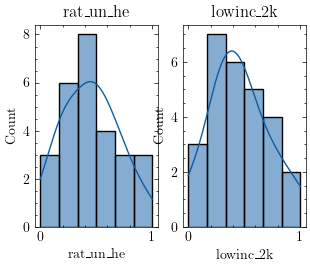

In [26]:
print(data[[v1, v2]].describe())

plt.subplot(1, 2, 1)
sns.histplot(data[v1], kde=True)
plt.title(v1)

plt.subplot(1, 2, 2)
sns.histplot(data[v2], kde=True)
plt.title(v2)

plt.show()

In [21]:
# Standardization check (if applicable)
# data_standardized = (data[[v1, v2]] - data[[v1, v2]].mean()) / data[[v1, v2]].std()
# print(data_standardized.describe())

          rat_un_he     lowinc_2k
count  2.800000e+01  2.800000e+01
mean   2.240271e-16  3.172066e-17
std    1.000000e+00  1.000000e+00
min   -1.813340e+00 -1.463410e+00
25%   -8.021881e-01 -6.775099e-01
50%   -7.745125e-02 -2.092501e-01
75%    7.088781e-01  3.828176e-01
max    2.219498e+00  3.314669e+00


Now, we have the data ready for the bivariate choropleth.

## 3. Binning

Categorization:
- 3 classes for each variable to be used in the choropleth, resulting in 9 classes in total

The first step is binning or simply putting variables into a set of intervals. There are many different ways how we can do it:

1. Use user-defined bins (*our approach*)
2. Calculate quantiles,
3. Use natural breaks and so on.

The "binning scheme" choice depends on the problem and the data. For example, you may want to discard extreme values on your map; then, quantiles can help. Perhaps, many of you are familiar with an excellent [mapclassify](https://github.com/pysal/mapclassify) package with many binning schemes implemented and explained. Check it out if you want to use other ways to do the binning.

**Importantly**, the number of bins made out of 2 variables must equal the number of categories you want to highlight in the choropleth. We will make 3 intervals for each of the variables to create 9 categories. You can also make 4 if you want or maybe even 25. Just make sure that the binning will give you these number of categories.

In [27]:
# Define the bins
bins = [0, 0.33, 0.66, 1]

# Bin the first variable - x
data['Var1_Class'] = pd.cut(data[v1], bins=bins, include_lowest=True)
data['Var1_Class'] = data['Var1_Class'].astype('str')

# Bin the second variable - y
data['Var2_Class'] = pd.cut(data[v2], bins=bins, include_lowest=True)
data['Var2_Class'] = data['Var2_Class'].astype('str')

# Code created x bins to 1, 2, 3
x_class_codes = np.arange(1, len(bins))
d = dict(zip(data['Var1_Class'].value_counts().sort_index().index, x_class_codes))
data['Var1_Class'] = data['Var1_Class'].replace(d)

# Code created y bins to A, B, C
y_class_codes = ['A', 'B', 'C']
d = dict(zip(data['Var2_Class'].value_counts().sort_index().index, y_class_codes))
data['Var2_Class'] = data['Var2_Class'].replace(d)

# Combine x and y codes to create Bi_Class
data['Bi_Class'] = data['Var1_Class'].astype('str') + data['Var2_Class']

c:\Users\libay\Envs\GIS\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\libay\Envs\GIS\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\libay\Envs\GIS\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [28]:
data

,PLN_AREA_N,rat_un_he,Name,lowinc_1k,lowinc_2k,lowinc_3k,geometry,rat_un_he_z,lowinc_2k_z,Var1_Class,Var2_Class,Bi_Class
0,ANG MO KIO,0.418033,kml_52,0.032053,0.817034,0.192010,"POLYGON ((30658.5 42047.527, 30679.195 42020.8...",-0.129822,0.947008,2,C,2C
1,BEDOK,0.403257,kml_1,0.027287,0.573058,0.157627,"POLYGON ((38974.269 36138.243, 39371.471 35747...",-0.190501,0.219210,2,B,2B
2,BISHAN,0.130810,kml_51,0.020294,0.263635,0.095917,"POLYGON ((29772.191 38311.805, 29784.826 38304...",-1.309399,-0.703820,1,A,1A
4,BUKIT BATOK,0.676856,kml_3,0.017531,0.514636,0.149146,"POLYGON ((20294.455 39114.528, 20334.318 39054...",0.933124,0.044934,3,B,3B
5,BUKIT MERAH,0.230853,kml_4,0.040185,0.989116,0.210762,"POLYGON ((26228.631 30746.197, 26231.96 30743....",-0.898538,1.460341,1,C,1C
6,BUKIT PANJANG,0.847033,kml_5,0.016969,0.262609,0.120975,"POLYGON ((21448.724 41356.741, 21508.535 40890...",1.632015,-0.706882,3,A,3A
7,BUKIT TIMAH,0.000000,kml_6,0.014158,0.003014,0.053597,"POLYGON ((24031.387 36694.742, 24076.658 36657...",-1.846616,-1.481271,1,A,1A
8,GEYLANG,0.194551,kml_53,0.029370,0.734703,0.191503,"POLYGON ((35619.754 32450.586, 35588.223 32427...",-1.047625,0.701408,1,C,1C
9,KALLANG,0.442844,kml_22,0.041820,1.000000,0.211753,"POLYGON ((31277.373 34723.293, 31305.947 34712...",-0.027923,1.492809,2,C,2C
10,NOVENA,0.262317,kml_25,0.025721,0.426950,0.132167,"POLYGON ((28297.1 35982.083, 28414.083 35789.2...",-0.769321,-0.216641,1,B,1B


## 3. Define colormap

Now we need to:
1. Select the colormap,
2. Ensure that the resulting variable **Bi_Class** matches it. 

**Joshua Stevens** has a great tutorial [here](https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and we are going to use one of the templated that he proposed there.

We just copy-paste the colors as a list and define a colormap from it.

In [30]:
colours = {
    '1A': '#e8e8e8', '1B': '#b0d5df', '1C': '#64acbe',
    '2A': '#e4acac', '2B': '#ad9ea5', '2C': '#627f8c',
    '3A': '#c85a5a', '3B': '#985356', '3C': '#574249'
}

In [31]:
data['colour'] = data['Bi_Class'].map(colours)
data.head()

c:\Users\libay\Envs\GIS\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,PLN_AREA_N,rat_un_he,Name,lowinc_1k,lowinc_2k,lowinc_3k,geometry,rat_un_he_z,lowinc_2k_z,Var1_Class,Var2_Class,Bi_Class,colour
0,ANG MO KIO,0.418033,kml_52,0.032053,0.817034,0.192010,"POLYGON ((30658.5 42047.527, 30679.195 42020.8...",-0.129822,0.947008,2,C,2C,#627f8c
1,BEDOK,0.403257,kml_1,0.027287,0.573058,0.157627,"POLYGON ((38974.269 36138.243, 39371.471 35747...",-0.190501,0.219210,2,B,2B,#ad9ea5
2,BISHAN,0.130810,kml_51,0.020294,0.263635,0.095917,"POLYGON ((29772.191 38311.805, 29784.826 38304...",-1.309399,-0.703820,1,A,1A,#e8e8e8
4,BUKIT BATOK,0.676856,kml_3,0.017531,0.514636,0.149146,"POLYGON ((20294.455 39114.528, 20334.318 39054...",0.933124,0.044934,3,B,3B,#985356
5,BUKIT MERAH,0.230853,kml_4,0.040185,0.989116,0.210762,"POLYGON ((26228.631 30746.197, 26231.96 30743....",-0.898538,1.460341,1,C,1C,#64acbe


## 4 & 5. Bivariate choropleth

C:\Users\libay\AppData\Local\Temp\ipykernel_18472\990875285.py:4: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  data.to_crs('EPSG:3857').plot(ax=ax,


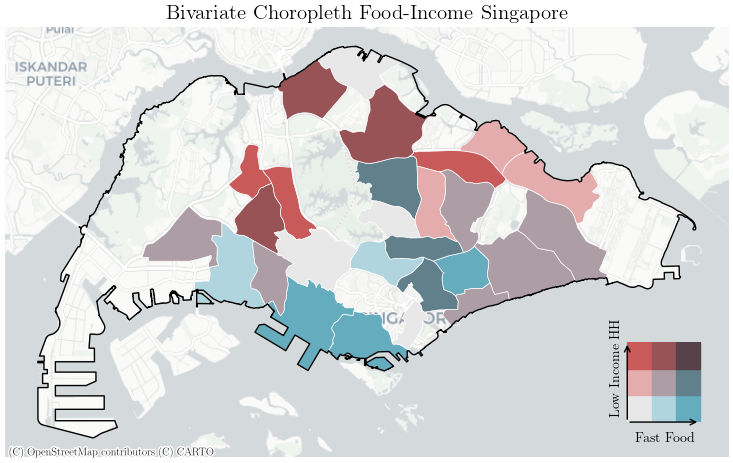

In [33]:
fig, ax = plt.subplots(figsize=(8,8))

# Step 1: Draw the map
data.to_crs('EPSG:3857').plot(ax=ax, 
                              column='Bi_Class', # variable that is going to be used to color the map 
                              color = data['colour'], # color of the map
                              edgecolor='white', # edge color of the map
                              linewidths=0.5, # edge weight of the map
                              categorical=True, # bivariate choropleth has to be colored as categorical map 
                              legend=False) # we're going to draw the legend ourselves
boundary.to_crs('EPSG:3857').plot(ax=ax, facecolor='none', edgecolor='black')

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron) # add the basemap

plt.tight_layout() # "tighten" two figures map and basemap
plt.axis('off') # we don't need axis with coordinates
ax.set_title('Bivariate Choropleth Food-Income Singapore', fontsize=15)

img2 = fig
ax2 = fig.add_axes([0.85, 0.275, 0.1, 0.1]) # add new axes to place the legend there and specify its location 
alpha = 1 # alpha argument to make it more/less transperent

for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=j/3, xmax=(j+1)/3, ymin=i/3, ymax=(i+1)/3, alpha=alpha, color=colours[f'{i+1}{y_class_codes[j]}'])

# Step 3: annoate the legend
ax2.tick_params(axis='both', which='both', length=0) # remove ticks from the big box
ax2.axis('off'); # turn off its axis
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for x 
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1)) # draw arrow for y 
ax2.text(s='Fast Food', x=0.1, y=-0.25) # annotate x axis
ax2.text(s='Low Income HH', x=-0.25, y=0.1, rotation=90); # annotate y axis
plt.savefig('bivariate_choropleth.svg', dpi=300) # save the figure to assigned format and path
#plt.show()

## References

* https://github.com/pysal/mapclassify
* https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
* https://en.wikipedia.org/wiki/Standard_score
* https://en.wikipedia.org/wiki/Winsorizing
* https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html